In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-sharing/SeoulBikeData.csv


In [2]:
# Load the dataset
file_path = "/kaggle/input/seoul-bike-sharing/SeoulBikeData.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Display first few rows
df.head()


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


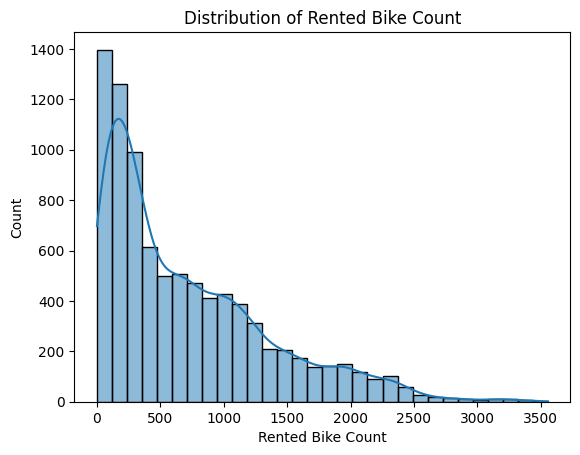

In [4]:
# Display dataset info
df.info()

# Check for missing values
df.isnull().sum()

# Summary statistics
df.describe()

# Visualize target variable
sns.histplot(df["Rented Bike Count"], bins=30, kde=True)
plt.title("Distribution of Rented Bike Count")
plt.show()


In [5]:
# Drop unnecessary columns
df = df.drop(columns=["Date"])

# Convert categorical features to one-hot encoding
categorical_features = ["Seasons", "Holiday", "Functioning Day"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["Rented Bike Count"]]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

# Define features and target variable
X = df.drop(columns=["Rented Bike Count"])
y = df["Rented Bike Count"]

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((7008, 12), (1752, 12), (7008,), (1752,))

In [6]:
svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", SVR(kernel="rbf"))
])

# Train SVM model
svm_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_pipeline.predict(X_test)


In [7]:
dt_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor(random_state=42))
])

# Train Decision Tree model
dt_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_pipeline.predict(X_test)


In [8]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train Random Forest model
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_pipeline.predict(X_test)


In [9]:
def evaluate(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)
    
    return {"Model": model_name, "MSE": mse, "MAE": mae, "R² Score": r2}

# Evaluate all models
results = []
results.append(evaluate(y_test, y_pred_svm, "Support Vector Machine"))
results.append(evaluate(y_test, y_pred_dt, "Decision Tree"))
results.append(evaluate(y_test, y_pred_rf, "Random Forest"))


Support Vector Machine Performance:
Mean Squared Error (MSE): 269496.0144
Mean Absolute Error (MAE): 351.3648
R² Score: 0.3532
----------------------------------------
Decision Tree Performance:
Mean Squared Error (MSE): 116119.1832
Mean Absolute Error (MAE): 193.8408
R² Score: 0.7213
----------------------------------------
Random Forest Performance:
Mean Squared Error (MSE): 57754.4747
Mean Absolute Error (MAE): 144.6059
R² Score: 0.8614
----------------------------------------


In [10]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
results_df


,Model,MSE,MAE,R² Score
0,Support Vector Machine,269496.014428,351.364787,0.353178
1,Decision Tree,116119.183219,193.840753,0.721300
2,Random Forest,57754.474749,144.605890,0.861382


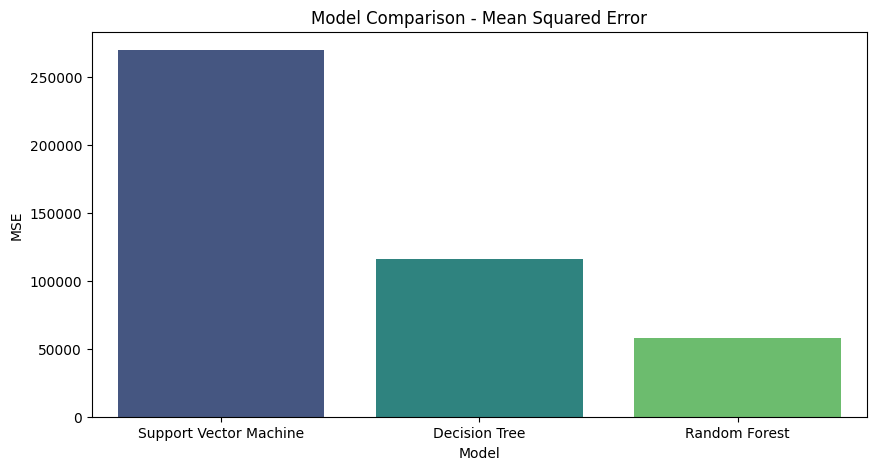

In [11]:
# Plot comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df["Model"], y=results_df["MSE"], palette="viridis")
plt.title("Model Comparison - Mean Squared Error")
plt.ylabel("MSE")
plt.show()
